In [1]:
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

## The task

This project is about predicting stock prices for different companies based on the data from the last 5 years. We gonna use data downloaded from yahoo using **pandas_datareader**. There will be couple of models presented and we goona choose the best one. Finally we will deploy the best model to the Streamlit app to predict prices in real time for the next 10 days. Since the new data is uploaded every day, we can retrain our model on it as well.

Lets read the data for a single company.

In [2]:
companies_dict = {
    'Amazon':'AMZN'
}
 
data_source = 'yahoo'
df = pdr.DataReader(list(companies_dict.values())[0], data_source)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-05-16,713.250000,700.280029,710.130005,710.659973,5432900,710.659973
2016-05-17,714.469971,693.909973,709.900024,695.270020,5121400,695.270020
2016-05-18,702.539978,688.760010,689.559998,697.450012,4283200,697.450012
2016-05-19,699.400024,689.559998,691.880005,698.520020,3025600,698.520020
2016-05-20,707.239990,700.000000,701.049988,702.799988,2916200,702.799988


In [4]:
df['Close'].index[-1]

Timestamp('2021-05-12 00:00:00')

For our purpose we gonna use the closing prices which are in the **Close** column. First we should check if there are no missing values.

In [5]:
df.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Lets also plot the data.

<AxesSubplot:xlabel='Date'>

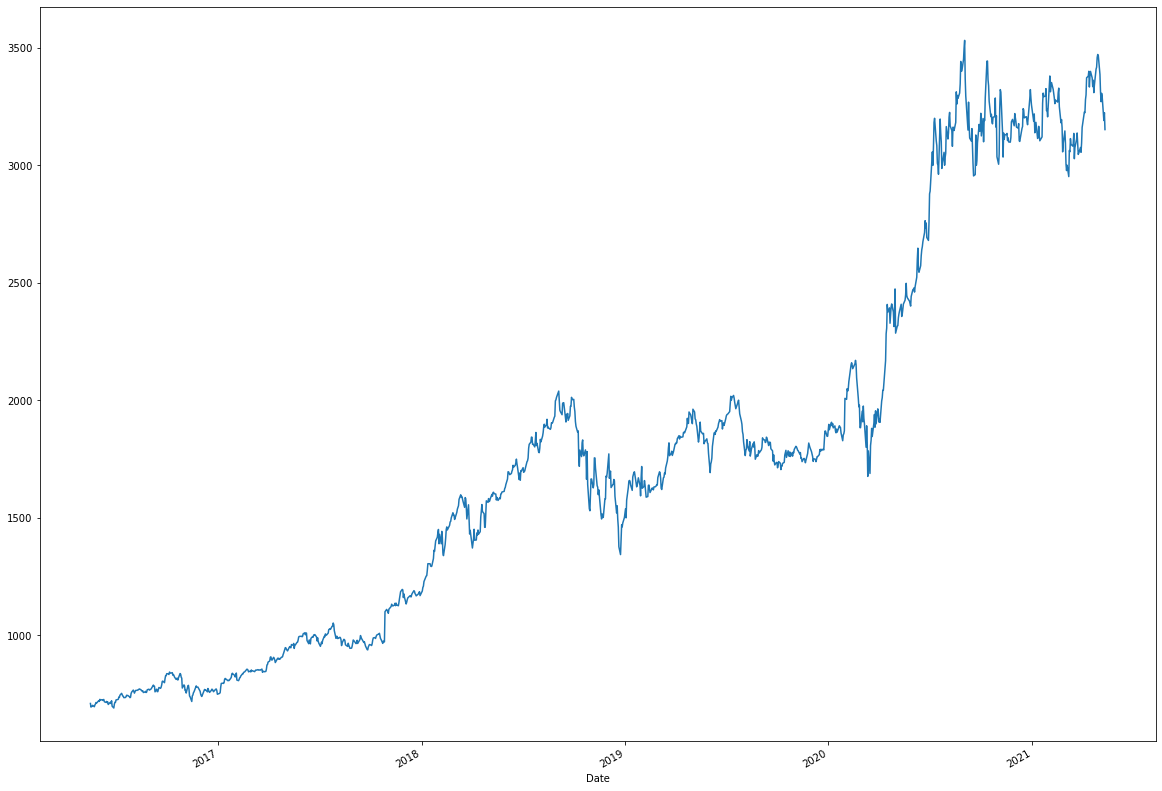

In [6]:
df['Close'].plot(figsize=(20,15))

## Preprocess data using windows

For the data preprocessing we gonna use tensorflow data API and window method which can be used for slicing sequences into smaller pieces easily. Firstly we will take windows of size 100 and predict next value. We would like to get as much data for training as possible and for this purpose we gonna shift each window by 1 step. This means that we will have highly overlapping windows. At the very beginning we should also scale our data.

In [7]:
df_close = df['Close']

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_close_scaled = scaler.fit_transform(df_close.values.reshape(-1, 1))

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(df_close_scaled)
n_steps = 100
window_length = n_steps + 1 
dataset = dataset.window(window_length, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda window: (window[:, :-1], window[:, -1]))

In [10]:
for X, y in dataset.take(1):
    print(X.shape, y.shape)

(32, 100, 1) (32, 1)


Now our data is preprocessed, batched and shuffled. We should also split it for the train and validation set. Since it is already shuffled we can simply take first 80% as a train set and leave the rest for validation. 

In [11]:
train_size = int(0.8 * len(list(dataset)))

train_set = dataset.take(train_size)
val_set = dataset.skip(train_size)

## seq2vector model

In [12]:
model = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [13]:
history = model.fit(train_set, epochs=50, validation_data=val_set)

Epoch 1/50
29/29 [==============================] - 8s 138ms/step - loss: 0.0868 - mse: 0.0868 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 2/50
29/29 [==============================] - 2s 71ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/50
29/29 [==============================] - 2s 68ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/50
29/29 [==============================] - 2s 69ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 5/50
29/29 [==============================] - 2s 71ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 6/50
29/29 [==============================] - 2s 69ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 7/50
29/29 [==============================] - 2s 73ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 8/50
29/29 [==============================] - 2s 75ms/step - loss: 0.0011 - 

In [14]:
pred = [model.predict(np.expand_dims(df_close_scaled[:i+100], axis=0))[0, 0] for i in range(len(df_close_scaled)- 100)]

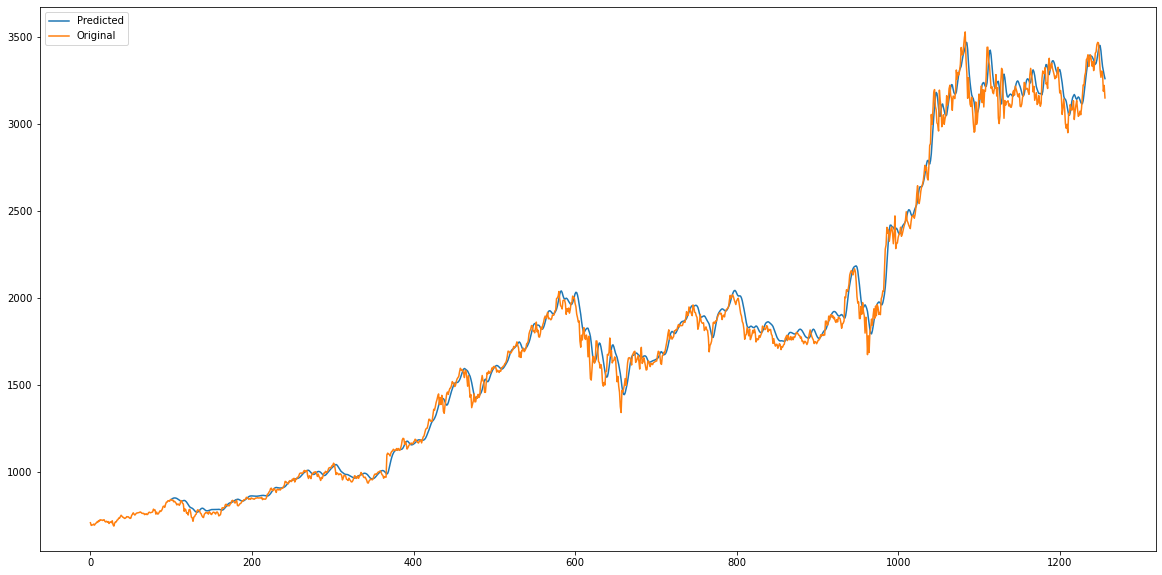

In [15]:
plt.figure(figsize=(20,10))
plt.plot(np.concatenate([np.nan * np.ones((n_steps, 1)), 
                         scaler.inverse_transform(np.expand_dims(np.array(pred), axis=1))]), label='Predicted')
plt.plot(scaler.inverse_transform(df_close_scaled), label='Original')
plt.legend()

## Predict future values

To predict prices for eg. next 10 days we can do the prediction for the next day, concatenate the result and make next prediction. This is the most basic method and also really bad since the error from every time step accumulates as we will see. This method should only be used for the next step prediction.

In [16]:
df_close_scaled_future = df_close_scaled.copy()

In [17]:
steps = 10
for step in range(steps):
    pred = model.predict(np.expand_dims(df_close_scaled_future, axis=0))
    df_close_scaled_future = np.concatenate([df_close_scaled_future, pred], axis=0)

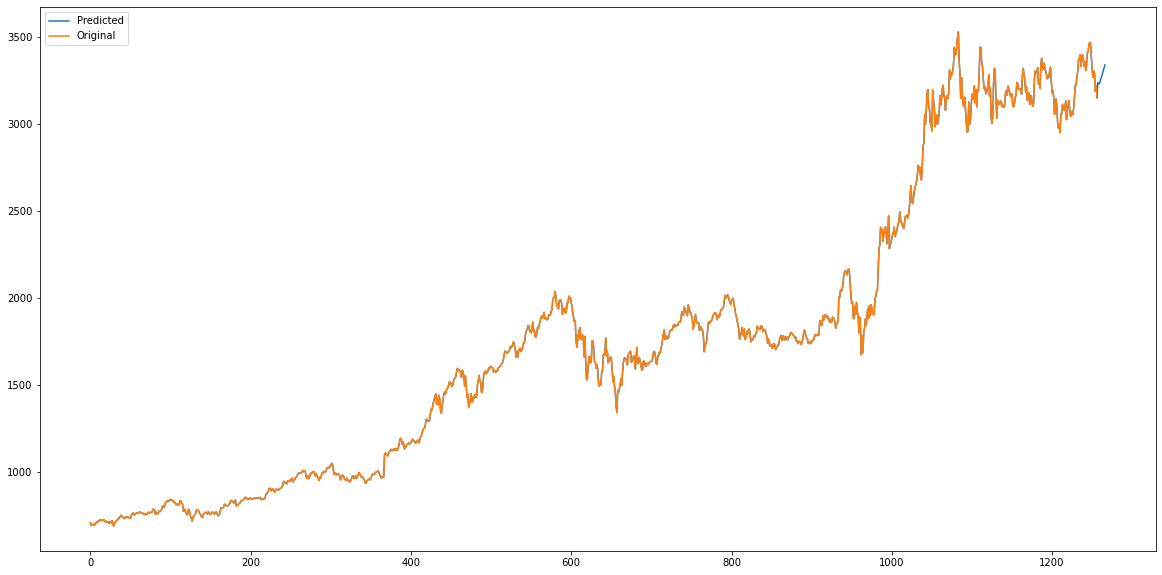

In [18]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df_close_scaled_future), label='Predicted')
plt.plot(scaler.inverse_transform(df_close_scaled), label='Original')
plt.legend()

## seq2seq model

We can modify our model to predict at each time step the next step. So the target will be equal to the input shifted 1 step ahead. Model has to be modified also so that there is an output at each time step. This can be achieved using TimeDistributed layer.

In [19]:
dataset = tf.data.Dataset.from_tensor_slices(df_close_scaled)
n_steps = 100
window_length = n_steps + 1 
dataset = dataset.window(window_length, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]))

In [20]:
for X, y in dataset.take(1):
    print(X.shape, y.shape)

(32, 100, 1) (32, 100, 1)


In [21]:
train_size = int(0.8 * len(list(dataset)))

train_set = dataset.take(train_size)
val_set = dataset.skip(train_size)

We can also define a custom metric for evaluation cause we are only interested in the last time step.

In [22]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [23]:
model = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

In [24]:
history = model.fit(train_set, epochs=100, validation_data=val_set)

Epoch 1/100
29/29 [==============================] - 7s 98ms/step - loss: 0.0763 - last_time_step_mse: 0.0786 - val_loss: 0.0128 - val_last_time_step_mse: 0.0031
Epoch 2/100
29/29 [==============================] - 2s 63ms/step - loss: 0.0111 - last_time_step_mse: 0.0022 - val_loss: 0.0067 - val_last_time_step_mse: 0.0012
Epoch 3/100
29/29 [==============================] - 2s 64ms/step - loss: 0.0080 - last_time_step_mse: 0.0012 - val_loss: 0.0073 - val_last_time_step_mse: 0.0011
Epoch 4/100
29/29 [==============================] - 2s 63ms/step - loss: 0.0064 - last_time_step_mse: 0.0011 - val_loss: 0.0061 - val_last_time_step_mse: 8.1271e-04
Epoch 5/100
29/29 [==============================] - 2s 64ms/step - loss: 0.0050 - last_time_step_mse: 7.3519e-04 - val_loss: 0.0044 - val_last_time_step_mse: 6.6791e-04
Epoch 6/100
29/29 [==============================] - 2s 66ms/step - loss: 0.0043 - last_time_step_mse: 6.5414e-04 - val_loss: 0.0042 - val_last_time_step_mse: 6.7999e-04
Epoch 7/

Epoch 48/100
29/29 [==============================] - 2s 69ms/step - loss: 2.3137e-04 - last_time_step_mse: 1.9666e-04 - val_loss: 2.3737e-04 - val_last_time_step_mse: 2.3594e-04
Epoch 49/100
29/29 [==============================] - 2s 69ms/step - loss: 2.2050e-04 - last_time_step_mse: 1.8552e-04 - val_loss: 2.2441e-04 - val_last_time_step_mse: 1.9768e-04
Epoch 50/100
29/29 [==============================] - 2s 69ms/step - loss: 2.4315e-04 - last_time_step_mse: 2.1089e-04 - val_loss: 3.2581e-04 - val_last_time_step_mse: 3.5009e-04
Epoch 51/100
29/29 [==============================] - 2s 69ms/step - loss: 2.7891e-04 - last_time_step_mse: 2.2196e-04 - val_loss: 2.2911e-04 - val_last_time_step_mse: 2.4511e-04
Epoch 52/100
29/29 [==============================] - 2s 69ms/step - loss: 2.2203e-04 - last_time_step_mse: 2.3580e-04 - val_loss: 2.2839e-04 - val_last_time_step_mse: 2.1393e-04
Epoch 53/100
29/29 [==============================] - 2s 69ms/step - loss: 2.2047e-04 - last_time_step_ms

29/29 [==============================] - 2s 69ms/step - loss: 1.7893e-04 - last_time_step_mse: 1.8748e-04 - val_loss: 1.8131e-04 - val_last_time_step_mse: 2.5624e-04
Epoch 94/100
29/29 [==============================] - 2s 69ms/step - loss: 1.8458e-04 - last_time_step_mse: 1.8375e-04 - val_loss: 1.8718e-04 - val_last_time_step_mse: 1.8799e-04
Epoch 95/100
29/29 [==============================] - 2s 70ms/step - loss: 1.8698e-04 - last_time_step_mse: 1.8752e-04 - val_loss: 1.9260e-04 - val_last_time_step_mse: 2.2978e-04
Epoch 96/100
29/29 [==============================] - 2s 69ms/step - loss: 1.7803e-04 - last_time_step_mse: 2.1021e-04 - val_loss: 1.9663e-04 - val_last_time_step_mse: 1.5885e-04
Epoch 97/100
29/29 [==============================] - 2s 70ms/step - loss: 1.8940e-04 - last_time_step_mse: 1.9316e-04 - val_loss: 1.9574e-04 - val_last_time_step_mse: 1.7881e-0468e-04 - last_tim
Epoch 98/100
29/29 [==============================] - 2s 70ms/step - loss: 1.8093e-04 - last_time_ste

In [25]:
pred = [model.predict(np.expand_dims(df_close_scaled[:i+100], axis=0))[0, -1, 0] for i in range(len(df_close_scaled) - 100)]

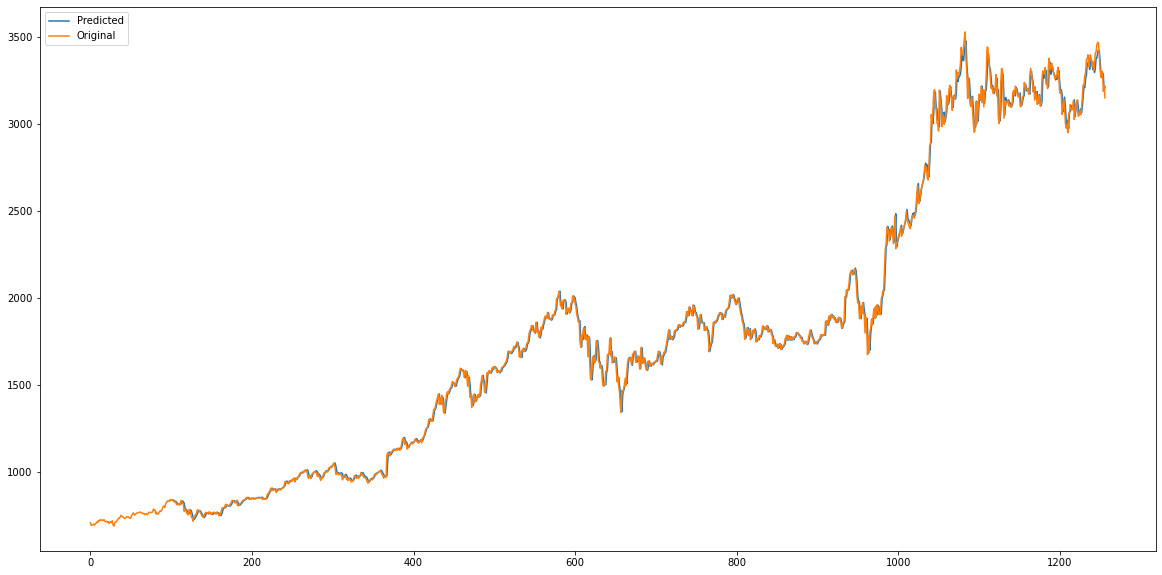

In [26]:
plt.figure(figsize=(20,10))
plt.plot(np.concatenate([np.nan * np.ones((n_steps, 1)), 
                         scaler.inverse_transform(np.expand_dims(np.array(pred), axis=1))]), label='Predicted')
plt.plot(scaler.inverse_transform(df_close_scaled), label='Original')
plt.legend()

## Predict future values

In [27]:
df_close_scaled_future = df_close_scaled.copy()

In [28]:
steps = 10
for step in range(steps):
    pred = model.predict(np.expand_dims(df_close_scaled_future, axis=0))[:, -1, :]
    df_close_scaled_future = np.concatenate([df_close_scaled_future, pred], axis=0)

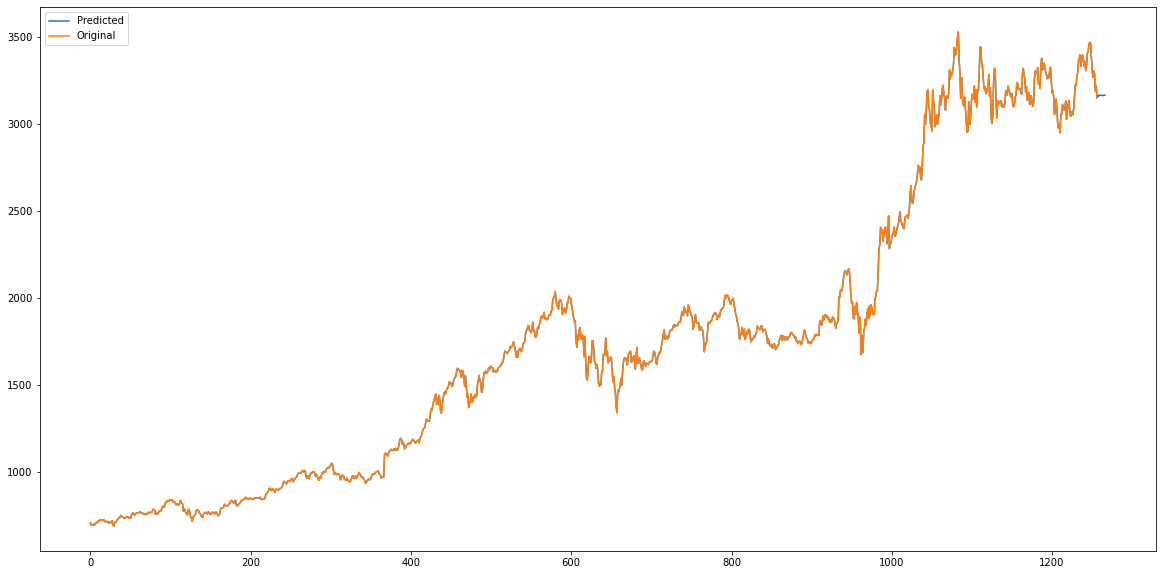

In [29]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df_close_scaled_future), label='Predicted')
plt.plot(scaler.inverse_transform(df_close_scaled), label='Original')
plt.legend()

Our sequence to sequence model can be used for predicting the next time step but it wont produce satisfying results if we want to predict eg. next 10 steps. One way to tackle it is to predict not only the next step but 10 next steps. We could see that predicting at every time step is better then predicting only the last step. Therefore our model can be modified to predict next 10 values at every time step.

## Predict 10 values at every step

Here we manually prepare our training data and targets.

In [30]:
num_steps = 100
X = [df_close_scaled[i:i+num_steps] for i in range(len(df_close_scaled)- (num_steps + 10))]

In [31]:
Y = np.empty((len(X), 100, 10))
for j in range(len(X)):
    for i in range(num_steps):
        Y[j, i, :] = df_close_scaled[i+j:j+i+10, 0]

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

In [33]:
for X, y in dataset.take(1):
    print(X.shape, y.shape)

(32, 100, 1) (32, 100, 10)


In [34]:
train_size = int(0.8 * len(list(dataset)))

train_set = dataset.take(train_size)
val_set = dataset.skip(train_size)

In [35]:
model = keras.models.Sequential([
    keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

In [36]:
history = model.fit(train_set, epochs=100, validation_data=val_set)

Epoch 1/100
28/28 [==============================] - 8s 114ms/step - loss: 0.1090 - last_time_step_mse: 0.1197 - val_loss: 0.0195 - val_last_time_step_mse: 0.0102
Epoch 2/100
28/28 [==============================] - 2s 65ms/step - loss: 0.0148 - last_time_step_mse: 0.0046 - val_loss: 0.0096 - val_last_time_step_mse: 0.0013
Epoch 3/100
28/28 [==============================] - 2s 67ms/step - loss: 0.0097 - last_time_step_mse: 0.0019 - val_loss: 0.0081 - val_last_time_step_mse: 0.0015
Epoch 4/100
28/28 [==============================] - 2s 70ms/step - loss: 0.0083 - last_time_step_mse: 0.0017 - val_loss: 0.0067 - val_last_time_step_mse: 0.0014
Epoch 5/100
28/28 [==============================] - 2s 66ms/step - loss: 0.0073 - last_time_step_mse: 0.0014 - val_loss: 0.0061 - val_last_time_step_mse: 0.0012
Epoch 6/100
28/28 [==============================] - 2s 68ms/step - loss: 0.0063 - last_time_step_mse: 0.0013 - val_loss: 0.0054 - val_last_time_step_mse: 0.0012
Epoch 7/100
28/28 [========

28/28 [==============================] - 2s 71ms/step - loss: 6.7413e-04 - last_time_step_mse: 6.7030e-04 - val_loss: 6.6555e-04 - val_last_time_step_mse: 7.5212e-04
Epoch 49/100
28/28 [==============================] - 2s 77ms/step - loss: 6.6964e-04 - last_time_step_mse: 6.8934e-04 - val_loss: 6.2485e-04 - val_last_time_step_mse: 6.2853e-04
Epoch 50/100
28/28 [==============================] - 2s 74ms/step - loss: 6.9880e-04 - last_time_step_mse: 7.2463e-04 - val_loss: 6.9416e-04 - val_last_time_step_mse: 7.0372e-04
Epoch 51/100
28/28 [==============================] - 2s 73ms/step - loss: 6.8944e-04 - last_time_step_mse: 6.9785e-04 - val_loss: 6.3747e-04 - val_last_time_step_mse: 6.4949e-04
Epoch 52/100
28/28 [==============================] - 2s 72ms/step - loss: 6.6509e-04 - last_time_step_mse: 7.3446e-04 - val_loss: 6.5493e-04 - val_last_time_step_mse: 5.5775e-04
Epoch 53/100
28/28 [==============================] - 2s 71ms/step - loss: 6.6427e-04 - last_time_step_mse: 7.2669e-04

Epoch 94/100
28/28 [==============================] - 2s 72ms/step - loss: 5.8643e-04 - last_time_step_mse: 7.1055e-04 - val_loss: 5.1586e-04 - val_last_time_step_mse: 6.2902e-04
Epoch 95/100
28/28 [==============================] - 2s 71ms/step - loss: 5.5332e-04 - last_time_step_mse: 5.6405e-04 - val_loss: 5.4524e-04 - val_last_time_step_mse: 5.8890e-04
Epoch 96/100
28/28 [==============================] - 2s 71ms/step - loss: 5.4617e-04 - last_time_step_mse: 5.4867e-04 - val_loss: 5.7063e-04 - val_last_time_step_mse: 6.3000e-04
Epoch 97/100
28/28 [==============================] - 2s 70ms/step - loss: 5.4858e-04 - last_time_step_mse: 6.6559e-04 - val_loss: 5.6696e-04 - val_last_time_step_mse: 6.2724e-04
Epoch 98/100
28/28 [==============================] - 2s 70ms/step - loss: 5.4065e-04 - last_time_step_mse: 5.6334e-04 - val_loss: 5.2920e-04 - val_last_time_step_mse: 5.1175e-04
Epoch 99/100
28/28 [==============================] - 2s 72ms/step - loss: 5.4101e-04 - last_time_step_ms

## Predict future values

To predict more than 10 next steps we can do the same thing as before, so concatenate predicted steps with our data and predict the next 10 steps and so on. This will accumulate error but our aim was to predict only 10 steps and for stock prices estimation we should not really need more.

In [37]:
df_close_scaled_future = df_close_scaled.copy()

In [38]:
pred = model.predict(np.expand_dims(df_close_scaled_future, axis=0))[:, -1, :]
df_close_scaled_future = np.concatenate([df_close_scaled_future, pred.T], axis=0)

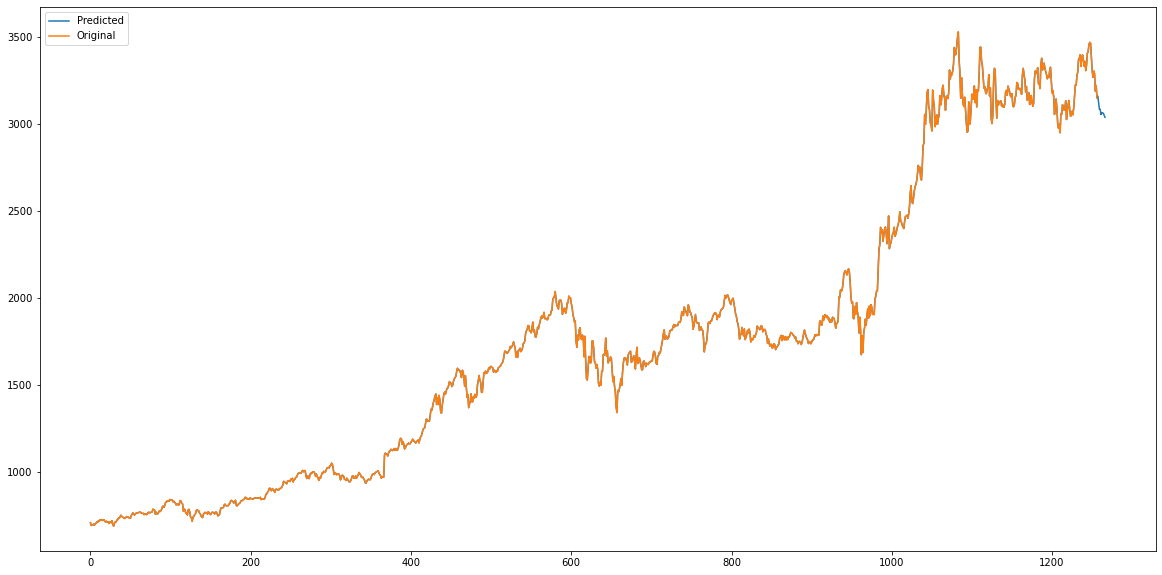

In [39]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df_close_scaled_future), label='Predicted')
plt.plot(scaler.inverse_transform(df_close_scaled), label='Original')
plt.legend()

## Using 1D Conv layer

Even better results can be achieved when we consider using 1D convolutional layer as the input layer. Conv layer shortens the sequences which can help our LSTM layers to capture longer patterns while at the same time it uses all the inputs. We can use stride of 1 and 'same' padding if we want to keep our output sequence length the same but with the 'valid' padding or stride greater than 1 output sequence has no longer the same length. Here we gonna use kernel size of 4 and stride of 2  with the 'valid' padding which will squeeze our input so that we will have to skip the first 3 time steps in the target and also take only every second step due to the stride.

In [40]:
num_steps = 100
X = [df_close_scaled[i:i+num_steps] for i in range(len(df_close_scaled)- (num_steps + 10))]

In [41]:
Y = np.empty((len(X), 100, 10))
for j in range(len(X)):
    for i in range(num_steps):
        Y[j, i, :] = df_close_scaled[i+j:j+i+10, 0]

In [42]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y[:, 3::2, :]))
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

In [43]:
for X, y in dataset.take(1):
    print(X.shape, y.shape)

(32, 100, 1) (32, 49, 10)


In [44]:
train_size = int(0.8 * len(list(dataset)))

train_set = dataset.take(train_size)
val_set = dataset.skip(train_size)

In [45]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])

In [46]:
history = model.fit(train_set, epochs=100, validation_data=val_set)

Epoch 1/100
28/28 [==============================] - 7s 75ms/step - loss: 0.1176 - last_time_step_mse: 0.1214 - val_loss: 0.0230 - val_last_time_step_mse: 0.0080
Epoch 2/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0201 - last_time_step_mse: 0.0053 - val_loss: 0.0142 - val_last_time_step_mse: 0.0024
Epoch 3/100
28/28 [==============================] - 1s 36ms/step - loss: 0.0127 - last_time_step_mse: 0.0020 - val_loss: 0.0094 - val_last_time_step_mse: 0.0015
Epoch 4/100
28/28 [==============================] - 1s 36ms/step - loss: 0.0095 - last_time_step_mse: 0.0017 - val_loss: 0.0083 - val_last_time_step_mse: 0.0018
Epoch 5/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0080 - last_time_step_mse: 0.0017 - val_loss: 0.0065 - val_last_time_step_mse: 0.0013
Epoch 6/100
28/28 [==============================] - 1s 37ms/step - loss: 0.0058 - last_time_step_mse: 0.0013 - val_loss: 0.0056 - val_last_time_step_mse: 0.0015
Epoch 7/100
28/28 [=========

28/28 [==============================] - 1s 39ms/step - loss: 6.1510e-04 - last_time_step_mse: 6.2952e-04 - val_loss: 6.2640e-04 - val_last_time_step_mse: 6.0884e-04
Epoch 49/100
28/28 [==============================] - 1s 37ms/step - loss: 5.9721e-04 - last_time_step_mse: 5.9822e-04 - val_loss: 6.5873e-04 - val_last_time_step_mse: 6.0810e-04
Epoch 50/100
28/28 [==============================] - 1s 37ms/step - loss: 6.5111e-04 - last_time_step_mse: 7.1950e-04 - val_loss: 6.5713e-04 - val_last_time_step_mse: 6.0981e-04
Epoch 51/100
28/28 [==============================] - 1s 37ms/step - loss: 6.1325e-04 - last_time_step_mse: 6.2799e-04 - val_loss: 5.7191e-04 - val_last_time_step_mse: 6.9825e-04
Epoch 52/100
28/28 [==============================] - 1s 37ms/step - loss: 5.8275e-04 - last_time_step_mse: 5.6786e-04 - val_loss: 6.4756e-04 - val_last_time_step_mse: 6.5419e-04
Epoch 53/100
28/28 [==============================] - 1s 38ms/step - loss: 6.2274e-04 - last_time_step_mse: 6.4361e-04

Epoch 94/100
28/28 [==============================] - 1s 37ms/step - loss: 5.4953e-04 - last_time_step_mse: 5.6929e-04 - val_loss: 5.3859e-04 - val_last_time_step_mse: 5.4269e-04
Epoch 95/100
28/28 [==============================] - 1s 37ms/step - loss: 5.7879e-04 - last_time_step_mse: 6.0713e-04 - val_loss: 5.9041e-04 - val_last_time_step_mse: 5.9103e-04
Epoch 96/100
28/28 [==============================] - 1s 37ms/step - loss: 5.7993e-04 - last_time_step_mse: 6.0959e-04 - val_loss: 5.6673e-04 - val_last_time_step_mse: 5.9488e-04
Epoch 97/100
28/28 [==============================] - 1s 37ms/step - loss: 5.9250e-04 - last_time_step_mse: 6.3454e-04 - val_loss: 5.5377e-04 - val_last_time_step_mse: 5.9151e-04
Epoch 98/100
28/28 [==============================] - 1s 38ms/step - loss: 5.8114e-04 - last_time_step_mse: 6.2140e-04 - val_loss: 5.7496e-04 - val_last_time_step_mse: 5.9740e-04
Epoch 99/100
28/28 [==============================] - 1s 38ms/step - loss: 5.9450e-04 - last_time_step_ms

## Predict future values

In [47]:
df_close_scaled_future = df_close_scaled.copy()

In [48]:
pred = model.predict(np.expand_dims(df_close_scaled_future, axis=0))[:, -1, :]
df_close_scaled_future = np.concatenate([df_close_scaled_future, pred.T], axis=0)

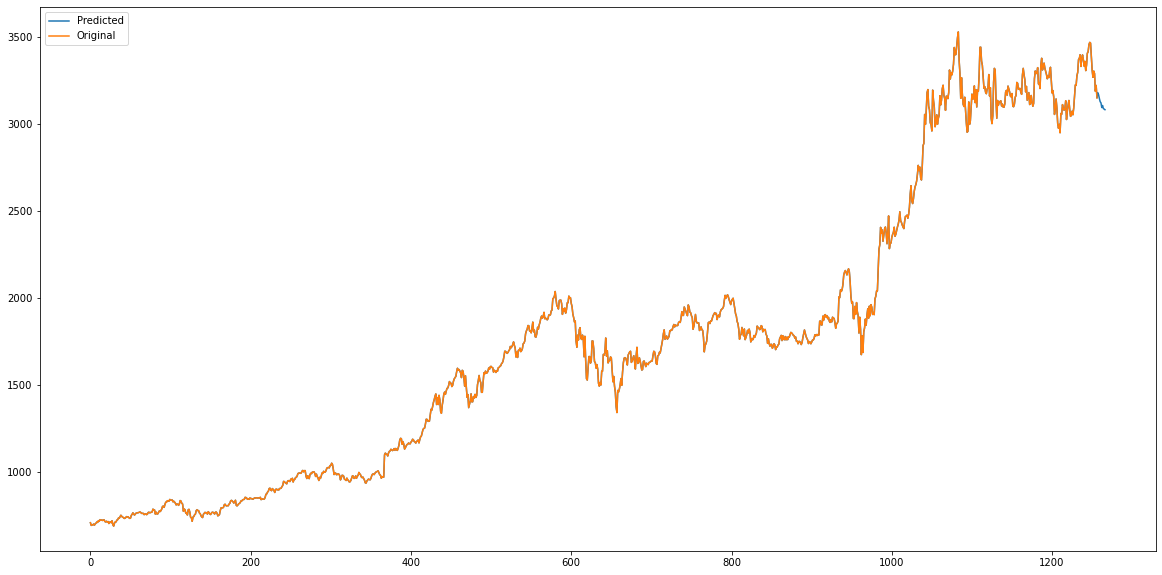

In [49]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df_close_scaled_future), label='Predicted')
plt.plot(scaler.inverse_transform(df_close_scaled), label='Original')
plt.legend()

Model with Conv layer converges much faster than the pure RNN model and training is also faster. MSE calculated for the last time step (10 future values) is similar in both cases. There is the last model to try which is build only from 1D Conv layers.

## Wavenet

Here Im gonna use the simplified version of the Wavenet model implemented in the Hands-On Machine Learning Book. Targets dont have to be modified cause every later outputs the sequence of the same length as the input. This is due to the 'causal' padding which acts like a 'valid' padding with the right amount of zeros on the left. Dilation rate defines how spread apart each neuron's inputs are at every layer.

In [50]:
num_steps = 100
X = [df_close_scaled[i:i+num_steps] for i in range(len(df_close_scaled) - (num_steps + 10))]

In [51]:
Y = np.empty((len(X), 100, 10))
for j in range(len(X)):
    for i in range(num_steps):
        Y[j, i, :] = df_close_scaled[i+j:j+i+10, 0]

In [52]:
dataset = tf.data.Dataset.from_tensor_slices((X, Y))
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)

In [53]:
for X, y in dataset.take(1):
    print(X.shape, y.shape)

(32, 100, 1) (32, 100, 10)


In [54]:
train_size = int(0.8 * len(list(dataset)))

train_set = dataset.take(train_size)
val_set = dataset.skip(train_size)

In [55]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

In [56]:
history = model.fit(train_set, epochs=200, validation_data=val_set)

Epoch 1/200
28/28 [==============================] - 1s 18ms/step - loss: 0.2032 - last_time_step_mse: 0.2402 - val_loss: 0.0854 - val_last_time_step_mse: 0.0951
Epoch 2/200
28/28 [==============================] - 0s 9ms/step - loss: 0.0525 - last_time_step_mse: 0.0536 - val_loss: 0.0169 - val_last_time_step_mse: 0.0108
Epoch 3/200
28/28 [==============================] - 0s 9ms/step - loss: 0.0133 - last_time_step_mse: 0.0071 - val_loss: 0.0056 - val_last_time_step_mse: 0.0020
Epoch 4/200
28/28 [==============================] - 0s 9ms/step - loss: 0.0044 - last_time_step_mse: 0.0020 - val_loss: 0.0025 - val_last_time_step_mse: 0.0013
Epoch 5/200
28/28 [==============================] - 0s 9ms/step - loss: 0.0026 - last_time_step_mse: 0.0015 - val_loss: 0.0019 - val_last_time_step_mse: 0.0014
Epoch 6/200
28/28 [==============================] - 0s 9ms/step - loss: 0.0016 - last_time_step_mse: 0.0011 - val_loss: 0.0012 - val_last_time_step_mse: 7.8839e-04
Epoch 7/200
28/28 [==========

28/28 [==============================] - 0s 10ms/step - loss: 6.7543e-04 - last_time_step_mse: 6.6070e-04 - val_loss: 6.2635e-04 - val_last_time_step_mse: 6.4251e-04
Epoch 48/200
28/28 [==============================] - 0s 9ms/step - loss: 6.9920e-04 - last_time_step_mse: 7.8226e-04 - val_loss: 9.5377e-04 - val_last_time_step_mse: 0.0011
Epoch 49/200
28/28 [==============================] - 0s 9ms/step - loss: 6.8757e-04 - last_time_step_mse: 7.1316e-04 - val_loss: 7.8320e-04 - val_last_time_step_mse: 9.8310e-04
Epoch 50/200
28/28 [==============================] - 0s 9ms/step - loss: 7.4379e-04 - last_time_step_mse: 7.1708e-04 - val_loss: 6.5272e-04 - val_last_time_step_mse: 7.9550e-04
Epoch 51/200
28/28 [==============================] - 0s 9ms/step - loss: 6.8051e-04 - last_time_step_mse: 7.0704e-04 - val_loss: 6.5193e-04 - val_last_time_step_mse: 8.4595e-04
Epoch 52/200
28/28 [==============================] - 0s 9ms/step - loss: 6.4856e-04 - last_time_step_mse: 6.6206e-04 - val_lo

28/28 [==============================] - 0s 9ms/step - loss: 6.0801e-04 - last_time_step_mse: 6.8639e-04 - val_loss: 6.1789e-04 - val_last_time_step_mse: 6.8727e-04
Epoch 94/200
28/28 [==============================] - 0s 9ms/step - loss: 6.1311e-04 - last_time_step_mse: 6.2351e-04 - val_loss: 6.9459e-04 - val_last_time_step_mse: 6.5377e-04
Epoch 95/200
28/28 [==============================] - 0s 9ms/step - loss: 6.6423e-04 - last_time_step_mse: 7.0767e-04 - val_loss: 6.4589e-04 - val_last_time_step_mse: 7.7069e-04
Epoch 96/200
28/28 [==============================] - 0s 9ms/step - loss: 5.7919e-04 - last_time_step_mse: 5.8762e-04 - val_loss: 7.5045e-04 - val_last_time_step_mse: 8.4098e-04
Epoch 97/200
28/28 [==============================] - 0s 9ms/step - loss: 6.1687e-04 - last_time_step_mse: 5.8761e-04 - val_loss: 6.0079e-04 - val_last_time_step_mse: 6.8073e-04
Epoch 98/200
28/28 [==============================] - 0s 9ms/step - loss: 6.3164e-04 - last_time_step_mse: 6.4245e-04 - val

Epoch 139/200
28/28 [==============================] - 0s 9ms/step - loss: 5.8200e-04 - last_time_step_mse: 6.4300e-04 - val_loss: 5.5537e-04 - val_last_time_step_mse: 6.6205e-04
Epoch 140/200
28/28 [==============================] - 0s 9ms/step - loss: 5.8745e-04 - last_time_step_mse: 6.1965e-04 - val_loss: 5.8665e-04 - val_last_time_step_mse: 6.0643e-04
Epoch 141/200
28/28 [==============================] - 0s 9ms/step - loss: 6.1314e-04 - last_time_step_mse: 6.1828e-04 - val_loss: 6.2666e-04 - val_last_time_step_mse: 7.8383e-04
Epoch 142/200
28/28 [==============================] - 0s 9ms/step - loss: 5.9322e-04 - last_time_step_mse: 5.9528e-04 - val_loss: 5.2739e-04 - val_last_time_step_mse: 5.1325e-04
Epoch 143/200
28/28 [==============================] - 0s 9ms/step - loss: 5.7857e-04 - last_time_step_mse: 6.4636e-04 - val_loss: 5.9549e-04 - val_last_time_step_mse: 6.7924e-04
Epoch 144/200
28/28 [==============================] - 0s 9ms/step - loss: 6.0747e-04 - last_time_step_ms

Epoch 185/200
28/28 [==============================] - 0s 9ms/step - loss: 5.4578e-04 - last_time_step_mse: 5.7550e-04 - val_loss: 5.6544e-04 - val_last_time_step_mse: 5.2512e-04
Epoch 186/200
28/28 [==============================] - 0s 9ms/step - loss: 5.6631e-04 - last_time_step_mse: 6.1980e-04 - val_loss: 5.7303e-04 - val_last_time_step_mse: 6.0992e-04
Epoch 187/200
28/28 [==============================] - 0s 9ms/step - loss: 6.0052e-04 - last_time_step_mse: 6.2499e-04 - val_loss: 5.1284e-04 - val_last_time_step_mse: 5.7472e-04
Epoch 188/200
28/28 [==============================] - 0s 9ms/step - loss: 5.5622e-04 - last_time_step_mse: 5.5819e-04 - val_loss: 5.4371e-04 - val_last_time_step_mse: 5.0321e-04
Epoch 189/200
28/28 [==============================] - 0s 9ms/step - loss: 5.6440e-04 - last_time_step_mse: 6.5135e-04 - val_loss: 5.7142e-04 - val_last_time_step_mse: 6.7185e-04
Epoch 190/200
28/28 [==============================] - 0s 9ms/step - loss: 5.7810e-04 - last_time_step_ms

## Predict future values

In [57]:
df_close_scaled_future = df_close_scaled.copy()

In [58]:
pred = model.predict(np.expand_dims(df_close_scaled_future, axis=0))[:, -1, :]
df_close_scaled_future = np.concatenate([df_close_scaled_future, pred.T], axis=0)

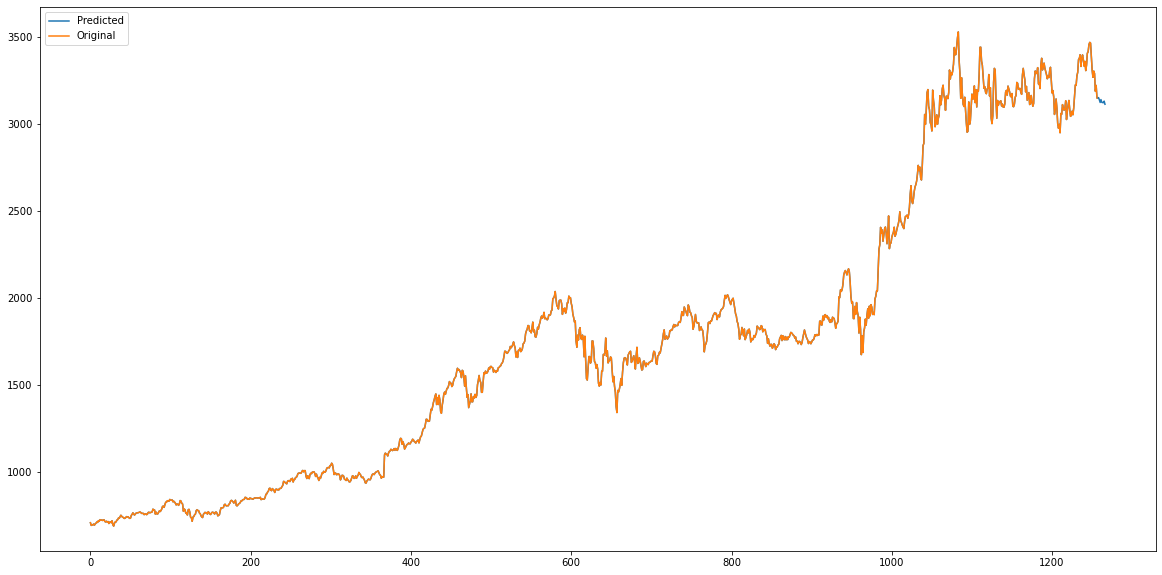

In [59]:
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(df_close_scaled_future), label='Predicted')
plt.plot(scaler.inverse_transform(df_close_scaled), label='Original')
plt.legend()

As we could see, Wavenet model is much faster then the model with just one Conv layer and also converges faster. I will use it in the app for live training.